### -1. To use with Google Colab or Kaggle Notebooks

In [1]:
# To use in Google Colab or Kaggle Notebooks
!pip install datasets==2.14.5
!pip install torch==2.0.0
!pip install transformers==4.34.0
!pip install tqdm==4.66.1
!pip install tokenizers==0.14.1
!pip install pandas==2.0.3
!pip install scikit-learn==1.3.1
!pip install matplotlib==3.8.0
!pip install --upgrade numpy==1.22.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstalled datasets-2.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0

### 0. Imports

In [2]:
# Importing Libraries
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from enum import Enum
import matplotlib.pyplot as plt


# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

cuda


### 1. Dataset Loading and Train_Validation_Test split

In this section, we load the dataset and split it into train, validation and test sets.

In [3]:
dataset = load_dataset("multi_woz_v22")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

Extracting data files:   0%|          | 0/22 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

### 2. Data Preprocessing and Formatting

In this section, we filter out the data to get only utterances whose services are labelled as "Restaurant" or "Hotel" and also convert the filtered data into dataframes for the X (utterances) and y (labels / service) sets for train, validation and test sets.

In [4]:

def filter_and_preprocess(data):
    """
    Filters a list of dictionaries by only including entries with services
    either "restaurant" or "hotel" and having only one service.

    Parameters:
    - data: list of dictionaries containing a "services" key, which is a list of services.

    Returns:
    - List of filtered dictionaries.
    """
    return [entry for entry in data if set(entry["services"]).issubset({"restaurant", "hotel"}) and len(entry["services"]) == 1]


train_data_filtered = filter_and_preprocess(train_data)
val_data_filtered = filter_and_preprocess(val_data)
test_data_filtered = filter_and_preprocess(test_data)

def toDataFrame(raw_data):
    # Initialize an empty list to store rows as dictionaries
    data = []

    # Loop through each dialogue in the training data
    for dialogue in raw_data:

        # Get the number of turns in this dialogue
        num_turns = len(dialogue['turns']['utterance'])

        # Loop through each turn in the dialogue
        for i in range(num_turns):

            # Extract the utterance and corresponding service for this turn
            utterance = dialogue['turns']['utterance'][i]
            service = dialogue['services']

            # Append as a dictionary to the data list
            data.append({'Utterance': utterance, 'Service': service})

    # Save data as pandas df
    df = pd.DataFrame(data)

    # Separate features and labels
    X = df['Utterance']
    Y = df['Service']
    
    return X, Y
        
X_train, Y_train = toDataFrame(train_data_filtered)
X_val, Y_val = toDataFrame(val_data_filtered)
X_test, Y_test = toDataFrame(test_data_filtered)

In [5]:
# Tokenization using BERT models

# Bert Models Enumeration
class BertModelsEnum(str, Enum):
    #bert_base_uncased = 'bert-base-uncased'
    #bert_base_cased = 'bert-base-cased'
    distilbert_base_uncased = 'distilbert-base-uncased'
    distilbert_base_cased = 'distilbert-base-cased'

bert_model_type = BertModelsEnum.distilbert_base_uncased.value
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_type)
def tokenize_data(X, Y):
    input_encoded = []
    attention_masks = []
    labels = []
    for x,y in zip(X,Y):
        encoded = tokenizer.encode_plus(
            x, 
            add_special_tokens=True, 
            max_length=256, 
            padding='max_length', 
            truncation=True, 
            return_attention_mask=True)
        input_encoded.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(0 if y[0] == 'hotel' else 1)
    return torch.tensor(input_encoded), torch.tensor(attention_masks), torch.tensor(labels)

train_input, train_masks, train_labels = tokenize_data(X_train, Y_train)
val_input, val_masks, val_labels = tokenize_data(X_val, Y_val)
test_input, test_masks, test_labels = tokenize_data(X_test, Y_test)

### 3. Loading the Data into DataLoaders for Training

We finally convert the dataframes into dataloaders for training and validation

In [6]:
batch_size = 64 # Adjust based on GPU memory requirements
num_workers = 2 # Adjust based on the number of CPU cores

train_data = TensorDataset(train_input, train_masks, train_labels)
val_data = TensorDataset(val_input, val_masks, val_labels)
test_data = TensorDataset(test_input, test_masks, test_labels)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### 4. Definition and Architecture of Classifier Model

We define the classifier model architecture and the forward function.

In [7]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model_type)
        self.fc = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :] # selects the [CLS] token position.
        logits = self.fc(cls_output)
        return logits

### 5. Training

We train the model on the train set and validate it on the validation set. We first define a class to save the best model during the training process.

In [8]:
class SaveModelWithBestValLoss:
    """
    Class that saves the best model during a training process. If the current epoch's validation loss 
    is smaller than the previous smallest validation loss saved, it saves the model state.
    The best valid loss is initialized to infinity.
    """
    def __init__(
        self, smallest_valid_loss=float('inf')
    ):
        self.smallest_valid_loss = smallest_valid_loss
        
    def save(
        self, current_valid_loss, epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.smallest_valid_loss:
            self.smallest_valid_loss = current_valid_loss
            print(f"Saving best model for epoch {epoch+1}, with new best validation loss: {self.smallest_valid_loss}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')

In [ ]:
model = BertClassifier()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-6)
criterion = nn.CrossEntropyLoss()

save_best_model_instance = SaveModelWithBestValLoss()

# For storing training and validation loss
train_losses = []
val_losses = []

for epoch in range(7):
    model.train()
    
    # Initialize tqdm progress bar
    train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    
    train_loss = 0.0
    for batch in train_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update training loss
        train_loss += loss.item()
        train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    val_loss = 0.0
    model.eval()

    # Initialize tqdm progress bar for validation
    val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    
    with torch.no_grad():
        for batch in val_bar:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Save model if validation model loss decreases
    save_best_model_instance.save(
        avg_val_loss, epoch, model, optimizer, criterion
    )

Validation Epoch 0: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s, validation_loss=0.120]


Epoch 0, Training Loss: 0.3548845391044413, Validation Loss: 0.3013488824168841
Saving best model for epoch 1, with new best validation loss: 0.3013488824168841



Validation Epoch 1: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s, validation_loss=0.114]


Epoch 1, Training Loss: 0.22885138854331394, Validation Loss: 0.28582483778397244
Saving best model for epoch 2, with new best validation loss: 0.28582483778397244



Validation Epoch 2:  72%|███████▏  | 13/18 [00:03<00:01,  3.83it/s, validation_loss=0.055]

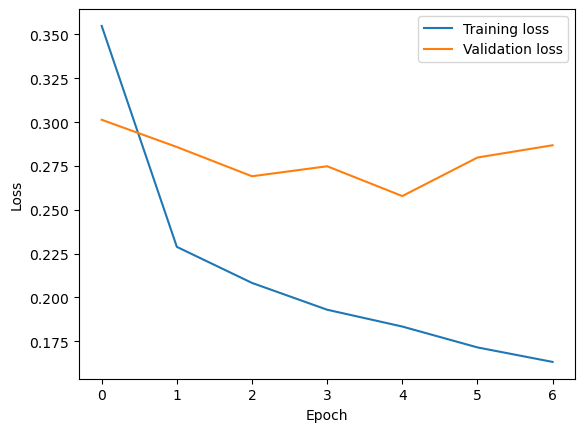

In [14]:
# Plotting validation and training loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### 6. Evaluation

We evaluate the best model on the Test Set. We first load the best model saved on the disk.

In [15]:
# build the model, without loading the pre-trained weights or fine-tune layers
saved_model = BertClassifier().to(device)
best_model = torch.load('best_model.pth')
saved_model.load_state_dict(best_model['model_state_dict'])

<All keys matched successfully>

Test: 100%|██████████| 22/22 [00:05<00:00,  3.88it/s]


Test Accuracy: 0.8371757925072046


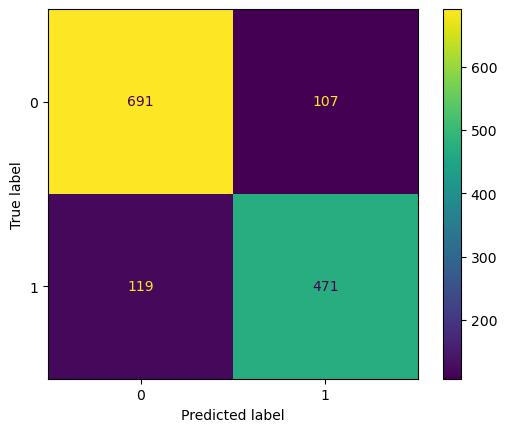

In [16]:

all_preds = []
all_labels = []

# Put the Saved Model in evaluation mode
saved_model.eval()

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar for validation
    val_bar = tqdm(test_loader, desc='Test')

    for batch in val_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = saved_model(input_ids, attention_mask)

        # Get the predicted labels
        _, preds = torch.max(logits, dim=1)

        # Move preds and labels to CPU for further evaluation (if using GPU)
        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the list of predictions and labels
        all_preds.extend(preds)
        all_labels.extend(labels)

# Evaluate the saved model's performance
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels,all_preds)
confusion_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
confusion_matrix_plot.plot()
plt.show()


### 7. Playground

We play with the model by giving it some utterances and seeing what it predicts.

In [18]:
def predict(model, sentence, tokenizer):
    model.eval()
    
    encoded = tokenizer.encode_plus(
        sentence, 
        add_special_tokens=True, 
        max_length=256, 
        padding='max_length', 
        truncation=True, 
        return_attention_mask=True)
    
    input_ids = torch.tensor([encoded['input_ids']], dtype=torch.long).to(device)
    attention_mask = torch.tensor([encoded['attention_mask']], dtype=torch.long).to(device)
    
    # Make a prediction
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    
    # Decode the prediction to label
    _, preds = torch.max(logits, dim=1)
    label = "hotel" if preds.item() == 0 else "restaurant"
    
    return label


sentence = "I would like to reserve for October 12th."
predicted_label = predict(saved_model, sentence, tokenizer)
print("Predicted label:", predicted_label)


Predicted label: hotel
